## Cognitive Battery Introduction: Jax-3DP3

In [121]:
import os
import numpy as np
import matplotlib.pyplot as plt
from jax3dp3.viz import save_depth_image, get_depth_image, multi_panel
from jax3dp3.utils import depth_to_coords_in_camera
from jax3dp3.transforms_3d import transform_from_pos
from jax3dp3.shape import (
    get_rectangular_prism_shape,
)
from jax3dp3.likelihood import threedp3_likelihood
import jax.numpy as jnp
import jax
from scipy.spatial.transform import Rotation as R
from jax3dp3.rendering import render_planes_multiobject
from jax3dp3.enumerations import make_translation_grid_enumeration
from jax3dp3.enumerations_procedure import enumerative_inference_single_frame
from jax3dp3.batched_scorer import batched_scorer_parallel_params
from jax3dp3.viz import make_gif_from_pil_images
from PIL import Image

from tqdm import tqdm

1. Initialize camera metadata and path to data:

In [130]:
scene = "relative"
data_path = f"/home/khaledshehada/cog_3dp3_data/{scene}_data/videos/"
num_frames = len(os.listdir(os.path.join(data_path, "frames")))

In [131]:
def get_camera_intrinsics(width, height, fov):
    cx, cy = width / 2.0, height / 2.0
    aspect_ratio = width / height
    fov_y = np.deg2rad(fov)
    fov_x = 2 * np.arctan(aspect_ratio * np.tan(fov_y / 2.0))
    fx = cx / np.tan(fov_x / 2.0)
    fy = cy / np.tan(fov_y / 2.0)

    return fx, fy, cx, cy


width = 300
height = 300
fov = 90

if fov:
    fx, fy, cx, cy = get_camera_intrinsics(width, height, fov)
else:
    fx = fy = cx = cy = 150

fx_fy = jnp.array([fx, fy])
cx_cy = jnp.array([cx, cy])

K = jnp.array(
    [
        [fx_fy[0], 0.0, cx_cy[0]],
        [0.0, fx_fy[1], cx_cy[1]],
        [0.0, 0.0, 1.0],
    ]
)

2. Load ground-truth RGB images, depth, and segmentation data.


In [132]:
rgb_images, depth_images, seg_maps = [], [], []
rgb_images_pil = []
for i in range(num_frames):
    rgb_path = os.path.join(data_path, f"frames/frame_{i}.jpeg")
    rgb_img = Image.open(rgb_path)
    rgb_images_pil.append(rgb_img)
    rgb_images.append(np.array(rgb_img))

    depth_path = os.path.join(data_path, f"depths/frame_{i}.npy")
    depth_npy = np.load(depth_path)
    depth_images.append(depth_npy)

    seg_map = np.load(os.path.join(data_path, f"segmented/frame_{i}.npy"))
    seg_maps.append(seg_map)

3. Mask the depth and segmentation images to only include the relevant part of the scene (i.e. crop to the box above table).

In [102]:
coord_images = []  # depth data in 2d view as images
seg_images = []  # segmentation data as images

for frame_idx in range(num_frames):
    coord_image, _ = depth_to_coords_in_camera(depth_images[frame_idx], K)
    segmentation_image = seg_maps[frame_idx]
    mask = np.invert(
        (coord_image[:, :, 0] < 1.0)
        * (coord_image[:, :, 0] > -1)
        * (coord_image[:, :, 1] < 0.467)
        * (coord_image[:, :, 1] > -0.8)
        * (coord_image[:, :, 2] < 1.95)
        * (coord_image[:, :, 2] > 1.15)
    )
    coord_image[mask, :] = 0.0
    segmentation_image[mask, :] = 0.0
    coord_images.append(coord_image)
    seg_images.append(segmentation_image)

coord_images = np.stack(coord_images)
seg_images = np.stack(seg_images)

4. Pick a starting frame and initialize the object shapes and poses from that frame

In [103]:
start_t = 2
seg_img = seg_images[start_t][:, :, 2]

imgs = []
for obj_id in jnp.unique(seg_img):
    imgs.append(get_depth_image(seg_img == obj_id))

In [104]:
shape_planes, shape_dims, init_poses = [], [], []
for obj_id in jnp.unique(seg_img):
    if obj_id == 0:
        continue
    obj_mask = seg_img == obj_id

    object_points = coord_images[start_t][obj_mask]
    maxs = np.max(object_points, axis=0)
    mins = np.min(object_points, axis=0)
    dims = maxs - mins
    center_of_box = (maxs + mins) / 2

    init_pose = transform_from_pos(center_of_box)
    init_poses.append(init_pose)

    shape, dim = get_rectangular_prism_shape(dims)
    shape_planes.append(shape)
    shape_dims.append(dim)
shape_planes = jnp.stack(shape_planes)
shape_dims = jnp.stack(shape_dims)
init_poses = jnp.stack(init_poses)

5. Save the reconstructed depths to check that they align with the actual depths.

In [105]:
def render_planes_multiobject_lambda(poses):
    return render_planes_multiobject(
        poses, shape_planes, shape_dims, height, width, fx, fy, cx, cy
    )


render_planes_multiobject_jit = jax.jit(render_planes_multiobject_lambda)

reconstruction_image = render_planes_multiobject_jit(init_poses)
save_depth_image(reconstruction_image[:, :, 2], "reconstruction.png", max=5.0)

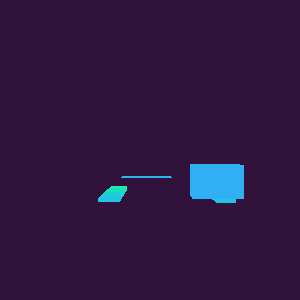

In [106]:
display(Image.open("reconstruction.png"))

6. Define the liklihood methods and the proposal enumerations.

In [ ]:
# Liklihood parameters
r = radius = 0.01
outlier_prob = 0.01

# Enumeration parameters
n = 7  # number of enumerated proposals on each dimension (x, y, z).
d = 0.1  # the minimum and maximum position delta on each dimension (x, y, z).

# Liklihood methods
def likelihood(x, params):
    obs = params[0]
    rendered_image = render_planes_multiobject(
        x, shape_planes, shape_dims, height, width, fx, fy, cx, cy
    )
    weight = threedp3_likelihood(obs, rendered_image, r, outlier_prob)
    return weight


likelihood_parallel = jax.vmap(likelihood, in_axes=(0, None))
batched_scorer_parallel_jit = jax.jit(
    lambda poses, image: batched_scorer_parallel_params(
        likelihood_parallel, n, poses, (image,)
    )
)

# Enumerating proposals
enumerations = make_translation_grid_enumeration(-d, -d, -d, d, d, d, n, n, n)

7. For each frame, enumerate the positions of new object poses (currently translation only), and for each object pick the pose that maximizes the 3DP3 liklihood under a uniform prior.

In [ ]:
num_steps = num_frames
inferred_poses = []
pose_estimates = init_poses.copy()
for t in tqdm(range(start_t, start_t + num_steps)):
    gt_image = jnp.array(coord_images[t])
    for i in range(pose_estimates.shape[0]):
        enumerations_full = jnp.tile(
            jnp.eye(4)[None, :, :],
            (enumerations.shape[0], pose_estimates.shape[0], 1, 1),
        )
        enumerations_full = enumerations_full.at[:, i, :, :].set(enumerations)
        proposals = jnp.einsum("bij,abjk->abik", pose_estimates, enumerations_full)

        weights = batched_scorer_parallel_jit(proposals, gt_image)
        pose_estimates = proposals[weights.argmax()]
    inferred_poses.append(pose_estimates.copy())

8. Get the reconstructed poses for each frame and save them as a gif file with the gt data

In [ ]:
all_images = []
for t in range(start_t, start_t + num_steps):
    rgb_viz = Image.fromarray(rgb_images[t].astype(np.int8), mode="RGB")
    gt_depth_1 = get_depth_image(coord_images[t][:, :, 2], max=5.0)
    depth = render_planes_multiobject_jit(inferred_poses[t - start_t])
    depth = get_depth_image(depth[:, :, 2], max=5.0)
    all_images.append(
        multi_panel(
            [rgb_viz, gt_depth_1, depth],
            ["RGB Image", "Actual Depth", "Reconstructed Depth"],
            middle_width=10,
            top_border=100,
            fontsize=20,
        )
    )
out_path = f"{scene}_out.gif"
make_gif_from_pil_images(all_images, out_path)
print("Saved output to:", out_path)